In [30]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [4]:
# Your code here

boston = pd.read_csv('boston_data.csv')
boston.head(5)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [6]:
boston.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [7]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [8]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


In [ ]:
#Ricardo found that infos about the columns:

''':Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town (this is terrible!!! i can belive that we are using a dataset that brings this information...)
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's'''

In [ ]:
#MEDV - is going to be our target.

In [14]:
#https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
#IQR is more robust then z score against outliers.
Q1 = boston.quantile(0.25)
Q3 = boston.quantile(0.75)
#interquartile range (IQR) = middle 50%
IQR = Q3 - Q1
print(IQR)

#Beatriz help me in this case in how to eliminate the outliers, but i will try with z score as well:

crim         3.970775
zn          12.500000
indus       12.910000
chas         0.000000
nox          0.178000
rm           0.726500
age         48.350000
dis          3.134250
rad         20.000000
tax        385.000000
ptratio      2.825000
black       21.297500
lstat        9.775000
medv         7.900000
dtype: float64


In [18]:
boston_zscore = (boston - boston.mean())/boston.std()
boston_zscore

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,-0.399394,-0.476559,-0.055746,-0.272550,-1.224937,-0.503751,-1.820761,0.705068,-0.660646,-0.623639,0.351322,0.231473,-0.392616,-0.069297
1,-0.405597,0.657036,-0.889212,-0.272550,-0.883991,-0.554060,-0.762546,1.484577,-0.207888,-0.746393,0.583848,0.442713,-0.487921,-0.306933
2,-0.378079,-0.476559,-0.189276,-0.272550,-0.108339,-0.487475,0.288542,-0.330424,-0.660646,-0.629484,-0.020720,0.435728,-0.379620,-0.227721
3,-0.111466,-0.476559,1.231139,-0.272550,2.678894,-1.042348,0.937010,-1.077752,-0.547456,-0.050786,-1.741415,-0.034059,1.278100,-0.782207
4,-0.412296,0.475661,-0.814376,-0.272550,-1.003322,-0.275884,-0.199590,1.428983,-0.660646,-0.986056,-0.764804,0.411704,-0.457597,-0.205089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.625920,-0.476559,1.013968,-0.272550,1.332158,-0.172307,1.072405,-0.728970,1.603144,1.486565,0.816374,0.442713,0.798690,-0.929315
400,5.300235,-0.476559,1.013968,-0.272550,0.343414,-0.805602,1.118724,-1.131167,1.603144,1.486565,0.816374,-3.730234,-0.359404,-0.827471
401,-0.415467,3.604383,-1.464422,3.659963,-1.327221,2.399344,-1.560661,0.988349,-1.000214,-1.249101,-2.252972,0.428108,-1.362989,3.133141
402,-0.414847,3.377664,-1.533388,-0.272550,-1.250508,0.120666,-1.172293,2.553625,-0.887025,-0.576875,-0.532278,0.442713,-0.986103,0.270184


In [26]:
z = np.abs(stats.zscore(boston))
print(z)

#the way above is wrong?
#anyway i don´t know to see if the is a lot of outliers and what they are:

[[0.39988956 0.47714971 0.05581469 ... 0.23175972 0.39310312 0.06938262]
 [0.40610035 0.65785078 0.89031483 ... 0.44326188 0.48852577 0.30731398]
 [0.3785481  0.47714971 0.18951101 ... 0.43626832 0.38009094 0.22800353]
 ...
 [0.41598186 3.60885208 1.46623746 ... 0.42863899 1.36467925 3.13702567]
 [0.41536167 3.38185198 1.53528941 ... 0.44326188 0.98732602 0.27051932]
 [0.40843331 0.88485088 0.91969864 ... 0.25793258 0.90202395 0.15721867]]


### Next, we want to explore the data. Pick several varibables you think will be most correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

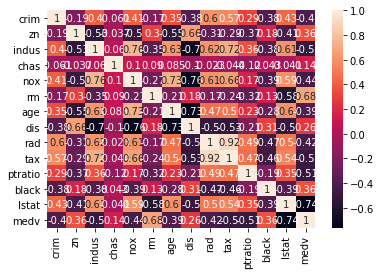

In [37]:
# Your plots here

x = boston.corr()
#sns.heatmap(boston.corr())

sns.heatmap(data= x, annot=True)


In [ ]:
#To fit a linear regression model, we select those features which have a high correlation with our target variable: MEDV in this case i will use the rm:



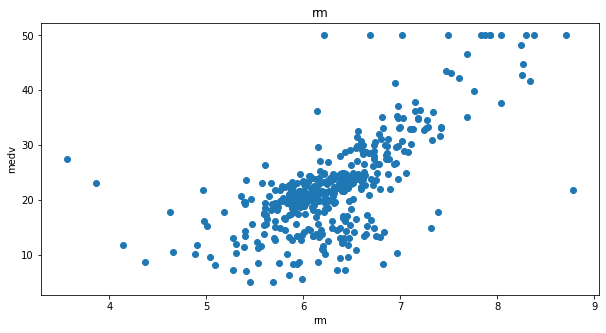

In [45]:
plt.figure(figsize=(10, 5))

features = ['rm']
target = boston['medv']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('medv')

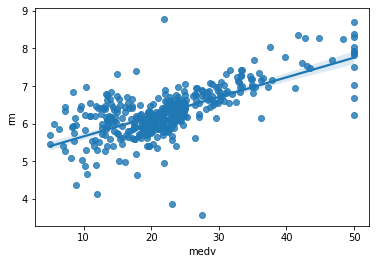

In [43]:
sns.regplot(x="medv", y="rm", data=boston)

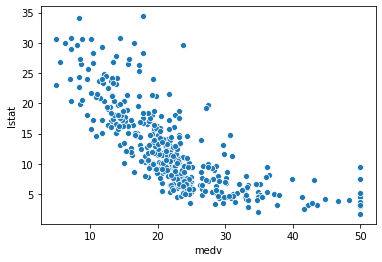

In [31]:
#plots for inverse correlation:
plt.figure()
sns.scatterplot(boston['medv'],boston['lstat'])

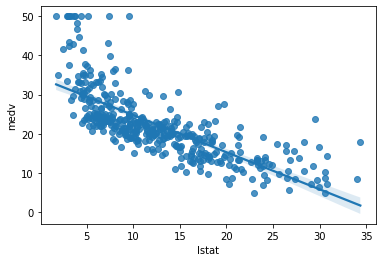

In [32]:

sns.regplot(x="lstat", y="medv", data=boston) #95%

In [40]:
#plt.figure()
#sns.scatterplot(boston['tax'],boston['rad'])

In [41]:
#sns.regplot(x="tax", y="rad", data=boston

In [ ]:
'''These feature pairs are strongly correlated to each other. 
We should not select both these features together for training the model.'''

In [ ]:
'''because of the correlation map, i belive that the columns that most have influence in the prices are tax and rad (full-value property-tax rate per USD 10,000 and index of accessibility to radial highways respectivly).
But i am seeing some outliers'''

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# Your response here




### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

In [ ]:
# Your response here

#i already did the heat map (above) and i think that i plot the two highest correlations (+ and -)

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [47]:
# Your code here
#boston.describe()
boston.iloc[:,-1].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [49]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    # Your code here:
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [53]:
# Your code here

#Google 
X = pd.DataFrame(np.c_[boston['lstat'], boston['rm']], columns = ['lstat','rm'])
y = boston['medv']


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(323, 2)
(81, 2)
(323,)
(81,)


----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [59]:
# Five separate RFR here with the given max depths

from sklearn.ensemble import RandomForestRegressor

rfr = [2,4,6,8,10]

for item in rfr:
    rf = RandomForestRegressor(n_estimators = 5, max_depth=item, random_state = 42) #random_state is for keep original sample
    rf.fit(X_train, y_train)# if i fit my model in here, i need to fit the linear 
    print(item, rf.score(X_test, y_test))

2 0.5614095846044658
4 0.6705705967563769
6 0.629178410504855
8 0.6152108591620187
10 0.5925579473753804


Now, plot the score for each tree on the training set and on the testing set.

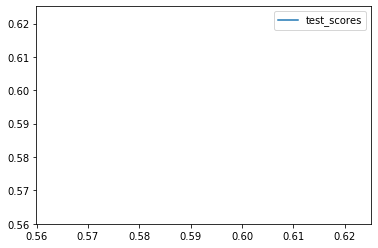

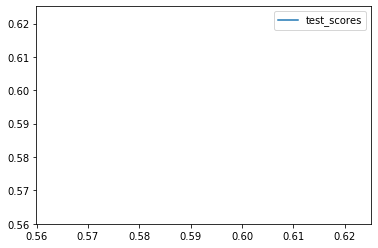

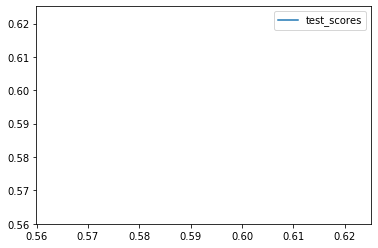

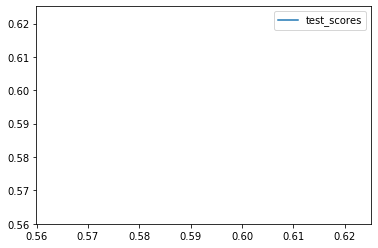

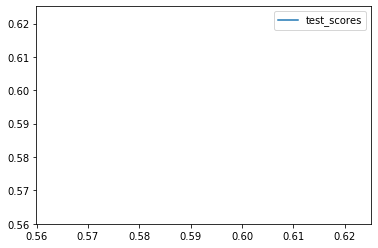

In [64]:
# Produce a plot with the score for the testing and training for the different max depths


#rf.score(X_train, y_train)


scores= [0.5614095846044658, 0.6705705967563769, 0.629178410504855, 0.6152108591620187, 0.5925579473753804]

max_depth=element

for element in scores:
    #plt.plot(max_depth, rf.score(X_train, y_train), label = 'train_scores')
    plt.plot(max_depth, rf.score(X_test, y_test), label = 'test_scores')
    plt.legend()
    plt.show()

    
#didn´t work, probably because i have only the numbers for x and y test...
# i am confused...


In [61]:
#beatriz way
max_depth = [2,4,6,8,10]
acc_train = []
acc_test= []

for item in max_depth:
    rf = RandomForestRegressor(n_estimators = 5, max_depth=item, random_state = 42) #random_state is for keep original sample
    rf.fit(X_train, y_train) #only one fit, training fit, right?
    acc_test.append(rf.score(X_test, y_test))
    acc_train.append(rf.score(X_train, y_train))
    
print(acc_train)
print(acc_test)

[0.7453932124960364, 0.8428061138909759, 0.902797693581345, 0.9170910257658618, 0.9280475819334959]
[0.5614095846044658, 0.6705705967563769, 0.629178410504855, 0.6152108591620187, 0.5925579473753804]


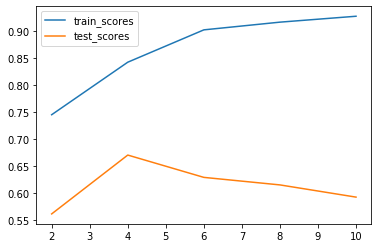

In [63]:
#Beatriz way
plt.plot(max_depth, acc_train, label = 'train_scores')
plt.plot(max_depth, acc_test, label = 'test_scores')
plt.legend()
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here

#I think that  i did somenthing wrong, because test and train are super differebt from each other.
#They needed to have some similarity, right?

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10?

In [65]:
# Your response here

max_depth = range(1,11)
acc_train = []
acc_test= []

for item in max_depth:
    rf = RandomForestRegressor(n_estimators = 5, max_depth=item, random_state = 42) #random_state is for keep original sample
    rf.fit(X_train, y_train) #only one fit, training fit, right?
    acc_test.append(rf.score(X_test, y_test))
    acc_train.append(rf.score(X_train, y_train))
    
print(acc_train)
print(acc_test)

[0.5052536834784858, 0.7453932124960364, 0.8144361366883202, 0.8428061138909759, 0.8796466291549592, 0.902797693581345, 0.9105501405064672, 0.9170910257658618, 0.9242317076081297, 0.9280475819334959]
[0.22277131177537382, 0.5614095846044658, 0.6406361021098895, 0.6705705967563769, 0.6425958482678558, 0.629178410504855, 0.6277413916783439, 0.6152108591620187, 0.5862829147476675, 0.5925579473753804]


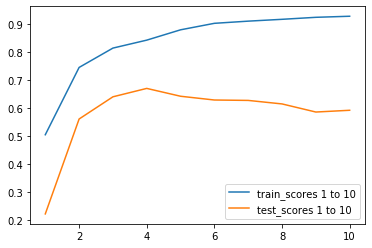

In [66]:

plt.plot(max_depth, acc_train, label = 'train_scores 1 to 10')
plt.plot(max_depth, acc_test, label = 'test_scores 1 to 10')
plt.legend()
plt.show()

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [ ]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here